# Analysis on European Renewable Energy and Carbon Emission

# Table of Contents
* [Introduction](#Introduction)
* [Data Description](#Data_Description)
* [Research Questions](#Research_Questions)
* [Data Acquisition](#Data_Acquisition)
    * [4.1 Countries in Europe](#Country_Lists_in_Europe)
    * [4.2 Renewable Energy Production Data](#Renewable_Energy_Production_Data)
    * [4.3 Carbon Emission from Climate Watch API ](#Carbon_Emission)
    * [4.4 Air Quality and Mortality Attributable to Ambient Air Pollution](#Air_Quality)
    * [4.5 Algricultural Production Index](#Production_Index)
* [Data Cleaning and Creating SQL Database](#Data_Cleaning)
* [Data Analysis](#Data_Analysis)
    * [6.1 Q1: What are the primary changes on renewable energy?](#Q1)
        * [6.1.1 Production of 5 renewable energy in Europe (2012-2021)](#Production)
        * [6.1.2 Changes of each renewable energy in 2012-2021 (Top 10 European countries))](#Changes)
    * [6.2 Q2. How do changes of carbon emission payback to national government?](#Q2)
        * [6.2.1 Correlation between Carbon Emissions and Algriculture Production Index](#cei)
        * [6.2.2 Correlation between Air Quality and Carbon Emissions](#cea)
        * [6.2.3 Air Pollution Attributable to Deaths](#ced)
        * [6.2.4 Correlation Heat Map](#heat)
    * [6.3 Q3. How effective is renewable energy as a solution to deal with carbon emission?](#Q3)
        * [6.3.1 Relation between Carbon Emissions and Renewable Energy](#relation)
* [Conclusion](#con)

# Introduction<a class="anchor" id="Introduction"></a>
Reducing carbon emission and achieving net-zero is becoming a more concerning topic globally. Following the United Nation’s goal of obtaining net-zero emission by 2050, national governments successively implemented policy in recent years. Answering the above questions will provide us with a clearer insight on how the use of renewable energy such as biofuel, solar, wind etc. affecting the global carbon emission and are the policies introduced by different countries making effective influence.

Previous research and analysis on the topic are focused on one aspect, for instance, reporting on how renewable energy is developed in recent years, or discovering the role of connection in renewable energy, carbon emissions and the countries. In this report, we will be focusing on European countries for the analysis, and aims to explore the relation between renewable energy use and carbon emissions, as well as identifying the bounding between carbon emission and governments.

Below are the modules we use in this project:

In [ ]:
#!pip install eurostat

In [ ]:
#!conda install cartopy --yes

In [ ]:
#!pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user && jupyter nbextension enable toc2/main

In [146]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pprint
import sys
import eurostat
from mpl_toolkits.mplot3d import Axes3D
import re
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import plotly.io as pio

# Data Description<a class="anchor" id="Data_Description"></a>
The data used in this projects comes from the following 5 different sources:

1. List of European countries scrapped from Wikipedia
    - This data is scrapped for the purpose of preparing country list for analysis.
2. Renewable Energy Production Data from Eurostat
    - Provides data for 5 types of renewable energy production (Geothermal, Solar thermal, Primary solid biofuels, Biogases, Renewable municipal waste), by the module eurostat.
3. Emissions data from Climate Watch
    - By using the API calls of Climate Watch, we can get the emission data of the countries we want.
4. Air Quality Health Risk Assessments from the European Environment Agency
    - This provides data for air quality and mortality attributable to ambient air pollution, we use as a indecator for effect to countries.
5. The FAO indices of agricultural production from the Food and Agriculture Organization of the United Nations (FAO)
    - This data is used to determine agricultural changes of countries in recent years.

# Research Questions<a class="anchor" id="Research_Questions"></a>
- What are the primary changes on renewable energy in Europe?
- How do changes of carbon emission payback to national government?
- How effective is renewable energy as a solution to deal with carbon emission?

# Data Acquisition<a class="anchor" id="Data_Acquisition"></a>

## Countries in Europe<a class="anchor" id="Country_Lists_in_Europe"></a>
As this project aims to analyse countries in Europe, it is therefore necessary to find out all the countries in Europe so we can filter out data only for European countries from the dataset during the analysis.I scrape a list of all European countries from this [Wikipedia](https://en.wikipedia.org/wiki/List_of_European_countries_by_area) page. The resulting list is as follows:

In [147]:
url = "https://en.wikipedia.org/wiki/List_of_European_countries_by_area"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', class_='wikitable sortable')
rows = table.find_all('tr')
countries_name = []
for row in rows:
    cells = row.find_all('td')
    if len(cells) > 0:
        country = cells[1].text.replace("*", "").strip()
        countries_name.append(country)
print(countries_name)

['Russia', 'Ukraine', 'France', 'Spain', 'Sweden', 'Norway', 'Germany', 'Finland', 'Poland', 'Italy', 'United Kingdom', 'Romania', 'Belarus', 'Kazakhstan', 'Greece', 'Bulgaria', 'Iceland', 'Hungary', 'Portugal', 'Serbia', 'Austria', 'Czechia', 'Ireland', 'Lithuania', 'Latvia', 'Croatia', 'Bosnia and Herzegovina', 'Slovakia', 'Estonia', 'Denmark', 'Switzerland', 'Netherlands', 'Moldova', 'Belgium', 'Albania', 'North Macedonia', 'Turkey', 'Slovenia', 'Montenegro', 'Azerbaijan', 'Georgia', 'Luxembourg', 'Andorra', 'Malta', 'Liechtenstein', 'San Marino', 'Monaco', 'Vatican City', 'Cyprus', 'Armenia']


In total we get 49 countries. However, we need to note that, due to some special characteristics of a few countries, for example, Vatican City and San Marino, not all of the countries in list is covered by our dataset. Therefore, we only analyse the countries in the list and covered by our dataset.

## Renewable Energy Production Data<a class="anchor" id="Renewable_Energy_Production_Data"></a>
The production of renewable energy data is accessed from Eurostat, including 5 types of renewable energy production (Geothermal, Solar thermal, Primary solid biofuels, Biogases, Renewable municipal waste) in EU from 2012 to 2021. Therefore, we seperate the dataset to five dataframe each representing one type of renewable energy. 

In [148]:
data = eurostat.get_data_df("NRG_CB_RW$DEFAULTVIEW")
data = data.drop('freq', axis=1)
data = data.drop('nrg_bal', axis=1)
data = data.drop('unit', axis=1)
# data = data.rename(columns={'geo\\TIME_PERIOD':'TIME'})
data = data.drop(data[data['geo\TIME_PERIOD']=="EA19"].index)
data = data.drop(data[data['geo\TIME_PERIOD']=="EA20"].index)
countries = {"AL":"Albania","AT":"Austria","BA":"Bosnia and Herzegovina","BE":"Belgium","BG":"Bulgaria","CY":"Cyprus","CZ":"Czechia","DE":"Germany (until 1990 former territory of the FRG)","DK":"Denmark",
            "EE":"Estonia","EL":"Greece","ES":"Spain","FI":"Finland","FR":"France","GE":"Georgia","HR":"Croatia","HU":"Hungary","IE":"Ireland","IS":"Iceland","IT":"Italy","LI":"Liechtenstein",
            "LT":"Lithuania","LU":"Luxembourg","LV":"Latvia","MD":"Moldova","ME":"Montenegro","MK":"North Macedonia","MT":"Malta","NL":"Netherlands","NO":"Norway","PL":"Poland","PT":"Portugal",
            "RO":"Romania","RS":"Serbia","SE":"Sweden","SI":"Slovenia","SK":"Slovakia","TR":"Türkiye","UA":"Ukraine","UK":"United Kingdom","XK":"Kosovo (under United Nations Security Council Resolution 1244/99)"}
solidBiofuels = data[data['siec']=="R5110-5150_W6000RI"]
solidBiofuels = solidBiofuels.replace({"geo\TIME_PERIOD":countries})
solidBiofuels = solidBiofuels.drop('siec', axis=1).reset_index().drop('index', axis=1)

Geothermal = data[data['siec']=="RA200"]
Geothermal = Geothermal.replace({"geo\TIME_PERIOD":countries})
Geothermal = Geothermal.drop('siec', axis=1).reset_index().drop('index', axis=1)

Biogases = data[data['siec']=="R5300"]
Biogases = Biogases.replace({"geo\TIME_PERIOD":countries})
Biogases = Biogases.drop('siec', axis=1).reset_index().drop('index', axis=1)

Solar = data[data['siec']=="RA410"]
Solar = Solar.replace({"geo\TIME_PERIOD":countries})
Solar = Solar.drop('siec', axis=1).reset_index().drop('index', axis=1)

waste = data[data['siec']=="W6210"]
waste = waste.replace({"geo\TIME_PERIOD":countries})
waste = waste.drop('siec', axis=1).reset_index().drop('index', axis=1)
solidBiofuels.head()

,geo\TIME_PERIOD,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Albania,8646.000,8436.000,8089.00,8555.000,7861.00,6896.078,6644.870,6577.550,6699.300,6335.390
1,Austria,208862.726,208770.105,192228.71,197300.653,200412.63,204295.481,193908.949,193203.912,195103.590,210924.956
2,Bosnia and Herzegovina,NaN,NaN,19489.00,24312.000,24368.00,20083.000,50346.000,52575.000,55323.000,53794.000
3,Belgium,82643.900,85469.400,70990.40,82884.000,85638.40,85699.600,83540.000,78594.200,77551.000,79358.800
4,Bulgaria,42791.000,43151.000,41599.00,43437.000,44370.00,44758.403,60317.759,63809.134,67369.764,74658.705


## Carbon Emission from Climate Watch API<a class="anchor" id="Carbon_Emission"></a>
Due to lack of data for carbon emissions, we decide to use greenhouse gas (GHG) emissions to indicate carbon emissions. Carbon dioxide is the most common greenhouse gas emitted by human activities, and it accounts for about four thirds of all greenhouse gas emissions.Therefore, we believe GHG emission will be a good indicator.

The way we import our data is by [Climate Watch API](https://www.climatewatchdata.org/data-explorer/historical-emissions). As it need the countries to be in the form of ISO code 3 to use this API, we first transfer the countries' names to the form we need by API calls of [REST Countries](https://restcountries.com/). The unit of emission value is Metric tons of carbon dioxide equivalent (MtCO₂e), and we only focus on emissions excluding LUCF (land-use change, and forestry) as we are more interested on the emissions by human activities.

In [149]:
countries_code = []
for country in countries_name:
    url = f'https://restcountries.com/v3/name/{country}?fullText=true&fields=cca3'
    r = requests.get(url)
    data1 = r.json()
    countries_code.append(data1[0]['cca3'])
datalist = []
for code in countries_code:
    r = requests.get(f'https://www.climatewatchdata.org/api/v1/data/historical_emissions?source_ids[]=160&gas_ids[]=401&sector_ids[]=1859&regions[]={code}')
    data2 = r.json()
    datalist.append(data2)

An example of the result is as follows:

In [150]:
datalist[0]['data'][0]['emissions']

[{'year': 1990, 'value': 3015.02},
 {'year': 1991, 'value': 2951.94},
 {'year': 1992, 'value': 2795.39},
 {'year': 1993, 'value': 2601.07},
 {'year': 1994, 'value': 2363.09},
 {'year': 1995, 'value': 2285.6},
 {'year': 1996, 'value': 2229.07},
 {'year': 1997, 'value': 2090.16},
 {'year': 1998, 'value': 2085.05},
 {'year': 1999, 'value': 2124.2},
 {'year': 2000, 'value': 2176.12},
 {'year': 2001, 'value': 2188.88},
 {'year': 2002, 'value': 2186.67},
 {'year': 2003, 'value': 2259.72},
 {'year': 2004, 'value': 2252.26},
 {'year': 2005, 'value': 2278.88},
 {'year': 2006, 'value': 2316.55},
 {'year': 2007, 'value': 2325.78},
 {'year': 2008, 'value': 2327.75},
 {'year': 2009, 'value': 2191.8},
 {'year': 2010, 'value': 2285.03},
 {'year': 2011, 'value': 2375.29},
 {'year': 2012, 'value': 2354.33},
 {'year': 2013, 'value': 2317.63},
 {'year': 2014, 'value': 2302.34},
 {'year': 2015, 'value': 2287.29},
 {'year': 2016, 'value': 2285.75},
 {'year': 2017, 'value': 2324.57},
 {'year': 2018, 'value'

## Air Quality and Mortality Attributable to Ambient Air Pollution<a class="anchor" id="Air_Quality"></a>
The dataset for air quality and mortality attributable to ambient air pollution is imported from the data for [Air Quality Health Risk Assessments](https://www.eea.europa.eu/data-and-maps/data/air-quality-health-risk-assessments) collected by European Environment Agency. In the dataset, values are available for four different types of pollutant, PM10, PM2.5, NO2 and O3. We decide to only use PM2.5 as the indicator, since it is the most common pollutant in our life nowadays. First few rows of the dataframe is shown below:

In [151]:
rawdata2 = pd.read_csv('data/air_quality_health_risk_assessments.csv')
pm2_5data = rawdata2[rawdata2['Air Pollutant'] == 'PM2.5']
allpm2_5data = pm2_5data[pm2_5data['Degree Of Urbanisation'] == 'All Areas (incl.unclassified)']
allpm2_5data.head()

,Country Or Territory,Degree Of Urbanisation,Year,Air Pollutant,Health Risk Scenario,Population,Populated Area [km2],Air Pollution Average [ug/m3],Air Pollution Population Weighted Average [ug/m3],Premature Deaths,Premature Deaths - lower CI,Premature Deaths - upper CI,Years Of Life Lost,Years Of Life Lost - lower CI,Years Of Life Lost - upper CI
9,Andorra,All Areas (incl.unclassified),2005,PM2.5,WHO_2021_AQG_Scen_Base,76874,56,11.4,13.5,38.0,29.0,43.0,455.0,347.0,508.0
24,Andorra,All Areas (incl.unclassified),2007,PM2.5,WHO_2021_AQG_Scen_Base,81221,56,12.4,14.8,45.0,34.0,51.0,569.0,435.0,635.0
33,Andorra,All Areas (incl.unclassified),2008,PM2.5,WHO_2021_AQG_Scen_Base,83136,56,10.6,12.5,37.0,28.0,41.0,455.0,348.0,509.0
45,Andorra,All Areas (incl.unclassified),2009,PM2.5,WHO_2021_AQG_Scen_Base,84483,56,10.9,13.3,41.0,31.0,45.0,517.0,394.0,577.0
57,Andorra,All Areas (incl.unclassified),2010,PM2.5,WHO_2021_AQG_Scen_Base,84081,56,10.4,13.6,43.0,33.0,48.0,536.0,408.0,597.0


## Algricultural Production Index<a class="anchor" id="Production_Index"></a>
The dataset for algricultural production index is collected by Food and Agriculture Organization of the United Nations (FAO).[The FAO indices](https://www.fao.org/faostat/en/#data/QI) of agricultural production represents the relative level of the aggregate volume of agricultural production for each year in comparison with the base period 2014-2016. In addition to renaming many of the variables, for the wholeness of all of our data, we select Gross Production Index Number instead of the version of per capita.

In [152]:
rawdata = pd.read_csv('data/Production_Indices_E_All_Data.csv',  encoding = 'ISO-8859-1')
rawdata = rawdata[(rawdata['Element'] == 'Gross Production Index Number (2014-2016 = 100)') & (rawdata['Item'] == 'Agriculture')]
rawdata.head()

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Unit,Y1961,...,Y2016,Y2016F,Y2017,Y2017F,Y2018,Y2018F,Y2019,Y2019F,Y2020,Y2020F
100,2,'004,Afghanistan,2051,'F2051,Agriculture,432,Gross Production Index Number (2014-2016 = 100),index,43.20,...,102.40,E,100.44,E,97.78,E,110.66,E,118.29,E
268,3,'008,Albania,2051,'F2051,Agriculture,432,Gross Production Index Number (2014-2016 = 100),index,22.80,...,103.05,E,103.72,E,105.95,E,102.77,E,105.46,E
442,4,'012,Algeria,2051,'F2051,Agriculture,432,Gross Production Index Number (2014-2016 = 100),index,22.32,...,102.89,E,103.04,E,108.56,E,112.20,E,112.40,E
544,7,'024,Angola,2051,'F2051,Agriculture,432,Gross Production Index Number (2014-2016 = 100),index,22.01,...,102.23,E,102.87,E,106.07,E,108.56,E,107.96,E
624,8,'028,Antigua and Barbuda,2051,'F2051,Agriculture,432,Gross Production Index Number (2014-2016 = 100),index,159.41,...,99.03,E,98.80,E,93.66,E,93.54,E,88.44,E


# Data Cleaning and Creating SQL Database<a class="anchor" id="Data_Cleaning"></a>
A SQL database created in this section, named as ceproject.db, since the amount of dataset we have is not less and data is miscellaneous from different sources. Therefore, a procedure is mostly appied for importing our data to our SQL database:
1. As our data have mostly been transfered to a pandas Dataframe, we want to select only the variables that could be relevant for the purposes of this analysis.
2. Handle missing data.
3. Drop duplicates.
4. Dealing with dtypes, and the problem that one countries can have different names.
4. Filter out the countries that are in our consideration and convert them into nested lists form.
5. Transform the nested lists into tables in SQL database by sqlite3 commands.

The way we handle missing data is different, we let the NaN stays in the Dataframe. When we convert the dataframe into nested lists form, we only keep the data that contains no NaN, which is simply done by a if command.

For renewable energy production data, one example of table in SQL database shown in pd.dataframe below:

In [153]:
def cleanDataFrame(df):
    return df.dropna(axis=1, how='all')
def tolistinlist(df,list):
    df = df.replace('Türkiye','Turkey')
    for c in countries_name:
        for a in range(len(df)):
            if c in df['geo\TIME_PERIOD'][a]:
                for y in years:
                    value = df[str(y)][a]
                    if np.isnan(value) == False:
                        temp = []
                        temp.append(c)
                        temp.append(y)
                        temp.append(df[str(y)][a])
                        list.append(temp)
energy = ['Geothermal','Solar thermal','Primary solid biofuels','Biogases','Renewable municipal waste']
years = [ i for i in  range(2012,2022)]
indigenous_production = []
Geothermall=[]
Solarl=[]
solidBiofuelsl=[]
Biogasesl=[]
wastel=[]

#Geothermal
Geothermal = cleanDataFrame(Geothermal)
tolistinlist(Geothermal, Geothermall)
indigenous_production.append(Geothermal[Geothermal['geo\TIME_PERIOD'] == 'EU27_2020'].values.tolist()[0][1:])

#Solar thermal
Solar = cleanDataFrame(Solar)
tolistinlist(Solar, Solarl)
indigenous_production.append(Solar[Solar['geo\TIME_PERIOD'] == 'EU27_2020'].values.tolist()[0][1:])

#Primary solid biofuels
solidBiofuels = cleanDataFrame(solidBiofuels)
tolistinlist(solidBiofuels,solidBiofuelsl)
indigenous_production.append(solidBiofuels[solidBiofuels['geo\TIME_PERIOD'] == 'EU27_2020'].values.tolist()[0][1:])

#Biogases
Biogases = cleanDataFrame(Biogases)
tolistinlist(Biogases,Biogasesl)
indigenous_production.append(Biogases[Biogases['geo\TIME_PERIOD'] == 'EU27_2020'].values.tolist()[0][1:])

#Renewable municipal waste
waste = cleanDataFrame(waste)
tolistinlist(waste,wastel)
indigenous_production.append(waste[waste['geo\TIME_PERIOD'] == 'EU27_2020'].values.tolist()[0][1:])
con = sqlite3.connect('ceproject.db')
con.execute('DROP TABLE IF EXISTS europe_Geothermal ;')
con.execute('''CREATE TABLE europe_Geothermal(
               country TEXT NOT NULL,
               year INTEGER NOT NULL,
               Geothermal REAL,
               PRIMARY KEY(country, year));''')
con.commit()
for n in Geothermall:
    con.execute('INSERT INTO europe_Geothermal VALUES(?, ?, ?);', n)
    con.commit()
con.commit()
con.execute('DROP TABLE IF EXISTS europe_Solar ;')
con.execute('''CREATE TABLE europe_Solar(
               country TEXT NOT NULL,
               year INTEGER NOT NULL,
               Solar REAL,
               PRIMARY KEY(country, year));''')
con.commit()
for n in Solarl:
    con.execute('INSERT INTO europe_Solar VALUES(?, ?, ?);', n)
    con.commit()
con.commit()
con.execute('DROP TABLE IF EXISTS europe_solidBiofuels ;')
con.execute('''CREATE TABLE europe_solidBiofuels(
               country TEXT NOT NULL,
               year INTEGER NOT NULL,
               solidBiofuels REAL,
               PRIMARY KEY(country, year));''')
con.commit()
for n in solidBiofuelsl:
    con.execute('INSERT INTO europe_solidBiofuels VALUES(?, ?, ?);', n)
    con.commit()
con.commit()
con.execute('DROP TABLE IF EXISTS europe_Biogases ;')
con.execute('''CREATE TABLE europe_Biogases(
               country TEXT NOT NULL,
               year INTEGER NOT NULL,
               Biogases REAL,
               PRIMARY KEY(country, year));''')
con.commit()
for n in Biogasesl:
    con.execute('INSERT INTO europe_Biogases VALUES(?, ?, ?);', n)
    con.commit()
con.commit()
con.execute('DROP TABLE IF EXISTS europe_waste ;')
con.execute('''CREATE TABLE europe_waste(
               country TEXT NOT NULL,
               year INTEGER NOT NULL,
               waste REAL,
               PRIMARY KEY(country, year));''')
con.commit()
for n in wastel:
    con.execute('INSERT INTO europe_waste VALUES(?, ?, ?);', n)
    con.commit()
con.commit()
Solar_df = pd.read_sql('''SELECT *
                          FROM europe_Solar;''', con)
con.close();
Solar_df.head()

,country,year,Solar
0,Ukraine,2012,0.0
1,Ukraine,2013,0.0
2,Ukraine,2014,0.0
3,Ukraine,2015,0.0
4,Ukraine,2016,0.0


For data of Carbon Emissions:

In [154]:
celist = []
for d in datalist:
    if d['data']:
         for ce in d['data'][0]['emissions']:
             temp = []
             temp.append(d['data'][0]['country'])
             temp.append(int(ce['year']))
             temp.append(float(ce['value']))
             celist.append(temp)
con = sqlite3.connect('ceproject.db')
con.execute('DROP TABLE IF EXISTS all_ghg_emissions_europe ;')
con.execute('''CREATE TABLE all_ghg_emissions_europe(
               country TEXT NOT NULL,
               year INTEGER NOT NULL,
               emission_value REAL NOT NULL,
               PRIMARY KEY(country, year));''')
con.commit()
for n in celist:
    con.execute('INSERT INTO all_ghg_emissions_europe VALUES(?, ?, ?);', n)
    con.commit()
con.commit()
con.close();

Here is a example of how the table of emission value looks like in our SQL database, with primary key (country, year).

In [155]:
con = sqlite3.connect('ceproject.db')
carbon_df = pd.read_sql('''SELECT *
                           FROM all_ghg_emissions_europe;''', con)
con.close();
carbon_df.head()

,country,year,emission_value
0,Russia,1990,3015.02
1,Russia,1991,2951.94
2,Russia,1992,2795.39
3,Russia,1993,2601.07
4,Russia,1994,2363.09


Data for air quality and mortality attributable to ambient air pollution:

In [156]:
airallpm2_5data = allpm2_5data[['Country Or Territory', 'Degree Of Urbanisation', 'Year', 'Population', 'Populated Area [km2]', 'Air Pollution Average [ug/m3]', 'Air Pollution Population Weighted Average [ug/m3]']]
deathallpm2_5data = allpm2_5data[['Country Or Territory', 'Degree Of Urbanisation', 'Year', 'Premature Deaths', 'Premature Deaths - lower CI', 'Premature Deaths - upper CI', 'Years Of Life Lost', 'Years Of Life Lost - lower CI', 'Years Of Life Lost - upper CI']]
airallpm2_5data = airallpm2_5data.dropna().reset_index(drop=True).drop(columns='Degree Of Urbanisation')
deathallpm2_5data = deathallpm2_5data.dropna().reset_index(drop=True).drop(columns='Degree Of Urbanisation')
deathallpm2_5datal = []
airallpm2_5datal = []

for c in countries_name:
    for a in range(len(airallpm2_5data)):
        if c in airallpm2_5data['Country Or Territory'][a]:
           airallpm2_5datal.append(airallpm2_5data.loc[a].tolist())
    for a in range(len(deathallpm2_5data)):
        if c in deathallpm2_5data['Country Or Territory'][a]:
           deathallpm2_5datal.append(deathallpm2_5data.loc[a].tolist())
airallpm2_5datal = [[f.item() if isinstance(f, np.int64) else f for f in sublist] for sublist in airallpm2_5datal]
deathallpm2_5datal = [[f.item() if isinstance(f, np.int64) else f for f in sublist] for sublist in deathallpm2_5datal]
con = sqlite3.connect('ceproject.db')
con.execute('DROP TABLE IF EXISTS pm2_5_pollution_all_areas ;')
con.execute('''CREATE TABLE pm2_5_pollution_all_areas(
               country TEXT NOT NULL,
               year INTEGER NOT NULL,
               population INTEGER NOT NULL,
               area INTEGER,
               pm2_5pollution REAL,
               pm2_5pollution_weighted REAL,
               PRIMARY KEY(country, year));''')
con.commit()
for n in airallpm2_5datal:
    con.execute('INSERT INTO pm2_5_pollution_all_areas VALUES(?, ?, ?, ?, ?, ?);', n)
    con.commit()
con.execute('DROP TABLE IF EXISTS pm2_5_lifedeath_all_areas ;')
con.execute('''CREATE TABLE pm2_5_lifedeath_all_areas(
               country TEXT NOT NULL,
               year INTEGER NOT NULL,
               pm2_5_Premature_Deaths INTEGER,
               pm2_5_Premature_Deaths_LCI INTEGER,
               pm2_5_Premature_Deaths_UCI INTEGER,
               pm2_5_Years_Of_Life_Lost INTEGER,
               pm2_5_Years_Of_Life_Lost_LCI INTEGER,
               pm2_5_Years_Of_Life_Lost_UCI INTEGER,
               PRIMARY KEY(country, year));''')
con.commit()
for n in deathallpm2_5datal:
    con.execute('INSERT INTO pm2_5_lifedeath_all_areas VALUES(?, ?, ?, ?, ?, ?, ?, ?);', n)
    con.commit()
   
con.close();

Here is the brief example of the tables (for all areas) that we import into our database with primary key (country, year) as before.

In [157]:
con = sqlite3.connect('ceproject.db')
air_df = pd.read_sql('''SELECT *
                    FROM pm2_5_pollution_all_areas;''', con)
death_df = pd.read_sql('''SELECT *
                    FROM pm2_5_lifedeath_all_areas;''', con)
con.close();
air_df.head()

,country,year,population,area,pm2_5pollution,pm2_5pollution_weighted
0,France,2005,60775741,370764,12.9,16.0
1,France,2007,61620204,370764,12.5,14.4
2,France,2008,61970776,370764,11.8,14.8
3,France,2009,62302927,370764,12.4,16.1
4,France,2010,62601755,370764,13.0,16.2


In [158]:
death_df.head()

,country,year,pm2_5_Premature_Deaths,pm2_5_Premature_Deaths_LCI,pm2_5_Premature_Deaths_UCI,pm2_5_Years_Of_Life_Lost,pm2_5_Years_Of_Life_Lost_LCI,pm2_5_Years_Of_Life_Lost_UCI
0,France,2005,38708,29619,43116,461772,353396,514346
1,France,2007,32787,25054,36567,415739,317601,463468
2,France,2008,34907,26686,38912,437386,334348,487467
3,France,2009,39673,30370,44188,498300,381425,555014
4,France,2010,40508,31012,45117,511574,391589,569772


For data of algricultural Production Index, we first change the names of the columns and change some names of countries to aviod failed and double reading:

In [159]:
header1 = ['Area']
header2 = ['Countries']
for x in range(1961, 2021, 1):
    x = str(x)
    header2.append(x)
    x = 'Y'+x
    header1.append(x)
rawdata = rawdata[header1]
rawdata = rawdata.set_axis(header2, axis=1)
rawdata = rawdata.replace('United Kingdom of Great Britain and Northern Ireland','United Kingdom')
rawdata = rawdata.replace('Türkiye','Turkey')

In [160]:
rawdata = rawdata.reset_index(drop=True)
newdata = []
for c in countries_name:
    for a in range(len(rawdata)):
        if c in rawdata['Countries'][a]:
            for y in range(1961, 2021, 1):
                value = rawdata[str(y)][a]
                if np.isnan(value) == False:
                    temp = []
                    temp.append(c)
                    temp.append(y)
                    temp.append(rawdata[str(y)][a])
                    newdata.append(temp)
con = sqlite3.connect('ceproject.db')
con.execute('DROP TABLE IF EXISTS europe_Gross_Production_Index_Number ;')
con.execute('''CREATE TABLE europe_Gross_Production_Index_Number(
               country TEXT NOT NULL,
               year INTEGER NOT NULL,
               indexnumber REAL NOT NULL,
               PRIMARY KEY(country, year));''')
con.commit()
for n in newdata:
    con.execute('INSERT INTO europe_Gross_Production_Index_Number VALUES(?, ?, ?);', n)
    con.commit()
con.commit()
con.close();

Here is a example of how the table of algricultural production index looks like in our SQL database, with primary key (country, year).

In [161]:
con = sqlite3.connect('ceproject.db')
index_df = pd.read_sql('''SELECT *
                          FROM europe_Gross_Production_Index_Number;''', con)
con.close();
index_df.head()

,country,year,indexnumber
0,Russia,1992,103.69
1,Russia,1993,97.88
2,Russia,1994,86.04
3,Russia,1995,79.97
4,Russia,1996,77.13


# Data Analysis<a class="anchor" id="Data_Analysis"></a>

## Q1: What are the primary changes on renewable energy?<a class="anchor" id="Q1"></a>
In this question, we would like to explore the changes on 5 renewable energy in Europe. The European map shows the distribution of total number of renewable energy in Europe, the 3D bar charts show the changes of Top 10 countries' production on each of the five renewable energy.

### Production of 5 renewable energy in Europe (2012-2021)<a class="anchor" id="Production"></a>

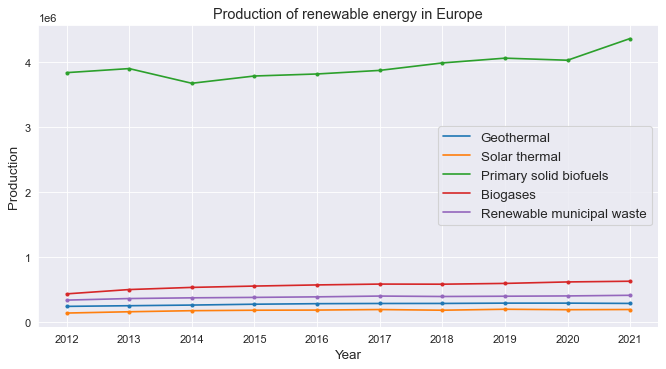

In [162]:
fig = plt.figure(figsize=(10, 5), dpi=80)

x = [ i for i in  range(len(years))]
cmap = plt.get_cmap('tab10')

for i in range(len(energy)):
    
    plt.plot(x, indigenous_production[i], label=energy[i],color=cmap(i))
    plt.scatter(x, indigenous_production[i],color=cmap(i),s=7)

plt.xticks(x, years)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Production',fontsize=12)
plt.title('Production of renewable energy in Europe',fontsize=13)
plt.legend(fontsize=12)
plt.show()

These data show a steady increase in capacity for geothermal energy, solar thermal, renewable municipal waste, biogas and biosolid fuels in the EU region from 2012 to 2021.

In [163]:
# bartChart of 2d
def getBartChartOfEnergy(Geothermal,energy_name):
    res = Geothermal.sort_values(by='2021', ascending=False)
    topTen_name = res.iloc[1:11,0].to_list()
    for i in range(10):
        if 'Germany' in topTen_name[i]:
            topTen_name[i]='Germany'
    eng = res.iloc[1:11,10].to_list()
    fig = plt.figure(figsize=(14, 3))
    x = [i for i in range(10)]
    cmap = plt.get_cmap('tab10')
    clors = [cmap(i) for i in range(10)]
    bars = plt.bar(x, eng,color=clors,alpha=0.5)
    min_d = 100000000
    max_d = 0
    for i, bar in enumerate(bars):
        if  min_d > bar.get_height():
            min_d = bar.get_height()
        if max_d < bar.get_height():
            max_d = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), eng[i], ha='center', va='bottom',fontsize=10)

    plt.xticks(x, topTen_name,rotation=30,fontsize=12)
    plt.title('Top 10 '+energy_name+' energy production in Europe in 2021')
    plt.xlabel('Country',fontsize=12)
    plt.ylim(ymax=max_d*1.2)
    plt.ylabel('Production',fontsize=15)
    plt.show()
    
    return topTen_name,eng

In [164]:
# bartChart of 3d
def get3dBart(new_ten_name,Solar,energy_name): 
    engs = []
    for name in new_ten_name:
        if 'Germany' in name:
            name = 'Germany (until 1990 former territory of the FRG)'
        eng1 = Solar[ Solar['geo\TIME_PERIOD']==name].values.tolist()[0][:]
        engs.append(eng1)
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['lightcoral','lightblue','lightcyan','lightgoldenrodyellow','lightgray','lightgreen','lightpink','lightsalmon','lightseagreen','lightskyblue']
    yticks = [ i for i in range(len(new_ten_name))]
    for c, k,aa in zip(colors,yticks,new_ten_name):
        xs = range(len(engs[k]))
        ys = engs[k]
        cs = [c] * len(xs)
        cs[0] = 'c'
        kk = [k for i in range(len(new_ten_name))]
        ax.bar(xs[1:],ys[1:] , zs=k, zdir='y', color=c,alpha = 1-0.03*k)
    ax.set_yticks(yticks)
    xs_label = [i for i in range(2012,2022,1)]
    
    plt.yticks(yticks,new_ten_name,fontsize=10)
    plt.xticks(xs[1:],xs_label,fontsize=10,rotation=30)
    plt.title('Top 10 '+energy_name+' energy production in Europe in 2012-2021',fontsize=15)
    plt.show()

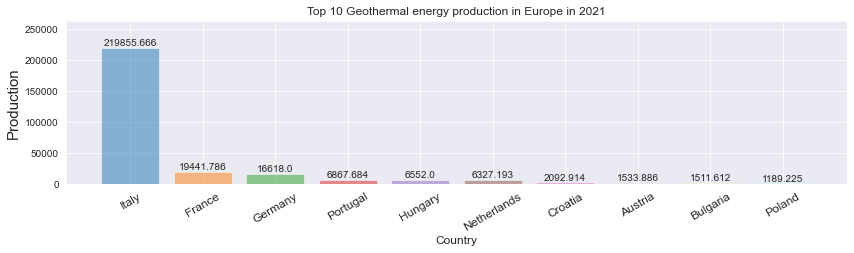

In [165]:
ten_geo,e = getBartChartOfEnergy(Geothermal,energy[0])
ten_geo.reverse() 

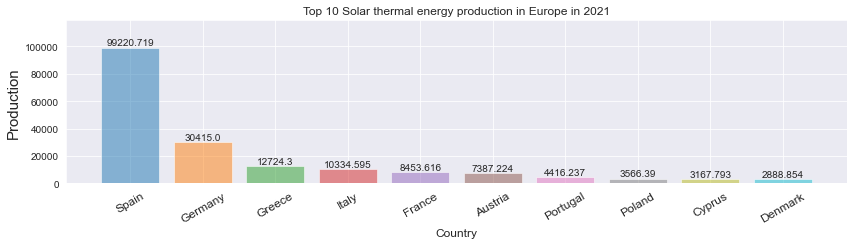

In [166]:
ten_sol,e = getBartChartOfEnergy(Solar,energy[1])
ten_sol.reverse()

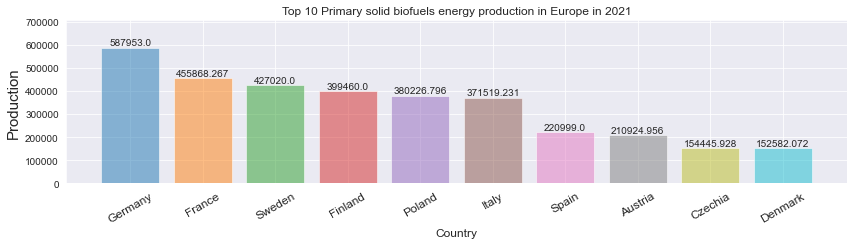

In [167]:
ten_pri, e = getBartChartOfEnergy(solidBiofuels,energy[2])
ten_pri.reverse()

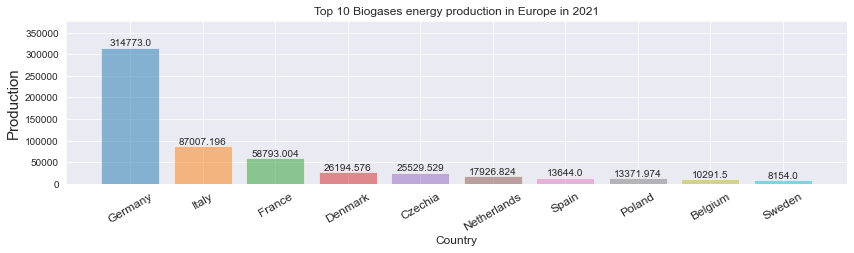

In [168]:
ten_bio, e = getBartChartOfEnergy(Biogases,energy[3])
ten_bio.reverse()

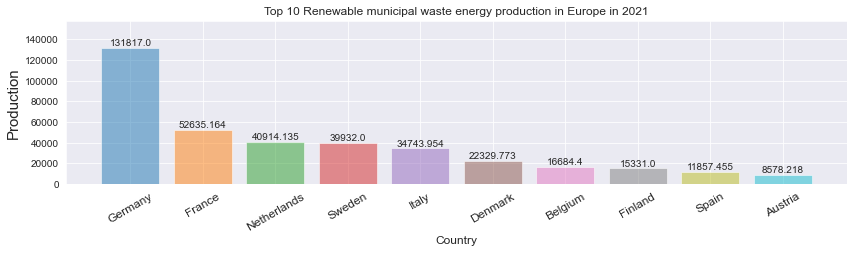

In [169]:
ten_ren,e=getBartChartOfEnergy(waste,energy[4])
ten_ren.reverse()

['Germany', 'Italy', 'France', 'Sweden', 'Finland', 'Poland', 'Spain', 'Austria', 'Denmark', 'Czechia']
[595191.8369999999, 475531.0, 423039.0, 404221.34099999996, 345729.243, 235109.18600000002, 204049.639, 184801.72600000002, 181110.61, 154554.745]


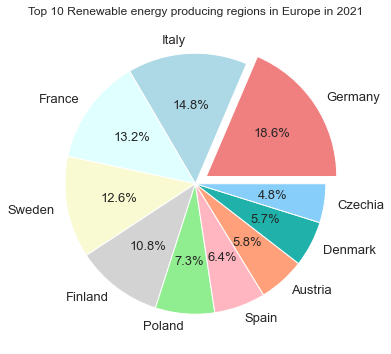

In [170]:
res = waste.add(Solar)
res = res.add(Geothermal)
res = res.add(solidBiofuels)
res = res.add(Biogases)

res = res.sort_values(by='2021', ascending=False)
topTen_name = res.iloc[1:11,0].to_list()

fig = plt.figure(figsize=(6, 6))

for i in range(10):
    if 'Germany' in topTen_name[i]:
        topTen_name[i]='Germany'
        continue
    index = int(len(topTen_name[i])/5)
    topTen_name[i]= topTen_name[i][0:index]
eng = res.iloc[3:13,10].to_list()

colors = ['lightcoral','lightblue','lightcyan','lightgoldenrodyellow','lightgray','lightgreen','lightpink','lightsalmon','lightseagreen','lightskyblue']

explode =[0.0 for i in range(10)]
explode[0]=0.1
patches,l_text,p_text = plt.pie(eng, labels=topTen_name, autopct='%1.1f%%',explode=explode,pctdistance = 0.6,colors=colors)

print(topTen_name)
print(eng)
for t in l_text:
    t.set_size(13)
for t in p_text:
    t.set_size(13)
    
plt.title('Top 10 Renewable energy producing regions in Europe in 2021')

plt.show()

In [171]:
res1 = res
res1 = res1.sort_values(by='2021', ascending=False)
topTen_name = res1.iloc[1:40,0].to_list()
for i in range(len(topTen_name)):
    if 'Germany' in topTen_name[i]:
        topTen_name[i]='Germany'
        continue
    if 'Kosovo' in topTen_name[i]:
        topTen_name[i] = 'Kosovo '
        continue
    index = int(len(topTen_name[i])/5)
    topTen_name[i]= topTen_name[i][0:index]

eng = res1.iloc[1:40,10].to_list()
max_value = max(eng)
data_dict = {}

for i in range(len(topTen_name)):
    data_dict[topTen_name[i]] = eng[i]

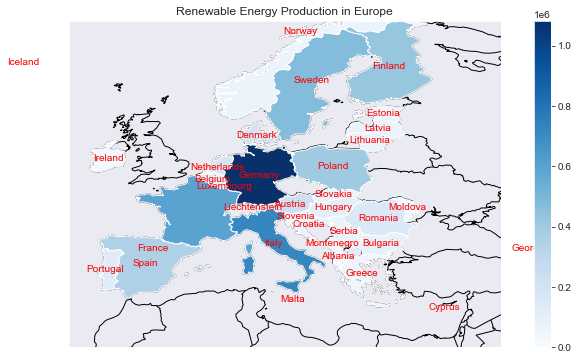

In [172]:
import warnings
from matplotlib.cbook import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
crs = ccrs.PlateCarree()

shpfilename = shpreader.natural_earth(resolution='50m', category='cultural',
                                      name='admin_0_countries')
readr = shpreader.Reader(shpfilename)
countries = readr.records()

cmap = plt.cm.get_cmap('Blues')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

ax.set_extent([-13, 40, 30, 70], crs=ccrs.PlateCarree())


for country in countries:
    name = country.attributes['NAME_LONG']
    match = re.search(r'\b\w+\b', name)
    if match:
        first_word = match.group()
        name = first_word
    
    if name in topTen_name:
        value = data_dict[name]
        if country.geometry.geom_type =='Polygon':
            ax.add_geometries([country.geometry], crs, facecolor=cmap((value+1000)/(max(eng))))
            center = country.geometry.centroid
            ax.text(center.x, center.y, name, ha='center', va='center', fontsize=10,color='r')
        else:
            ax.add_geometries(country.geometry, crs, facecolor=cmap((value+1000)/(max(eng))))
            center = country.geometry.centroid
            ax.text(center.x, center.y, name, ha='center', va='center', fontsize=10,color='r')

plt.title('Renewable Energy Production in Europe')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_value))
sm._A = []
plt.colorbar(sm)

plt.show()

### Changes of each renewable energy in 2012-2021 (Top 10 European countries)<a class="anchor" id="Changes"></a>

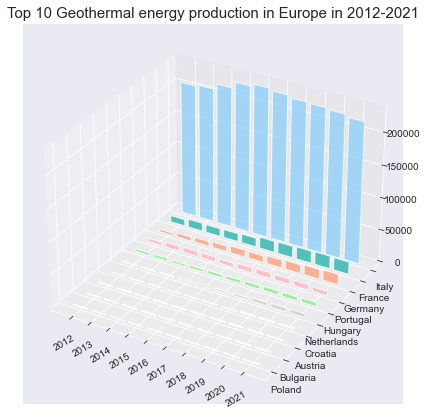

In [173]:
get3dBart(ten_geo,Geothermal,energy[0])

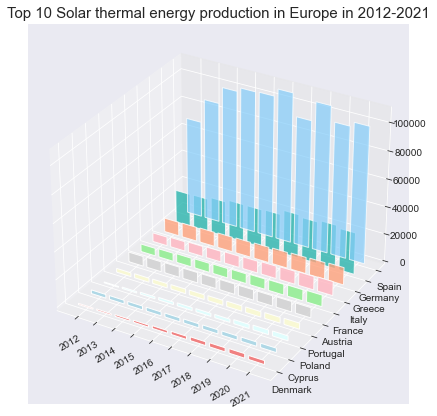

In [174]:
get3dBart(ten_sol,Solar,energy[1])

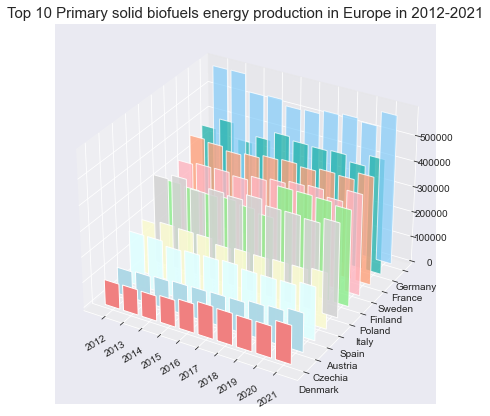

In [175]:
get3dBart(ten_pri,solidBiofuels,energy[2])

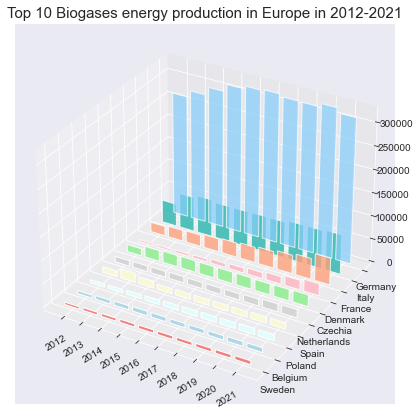

In [176]:
get3dBart(ten_bio,Biogases,energy[3])

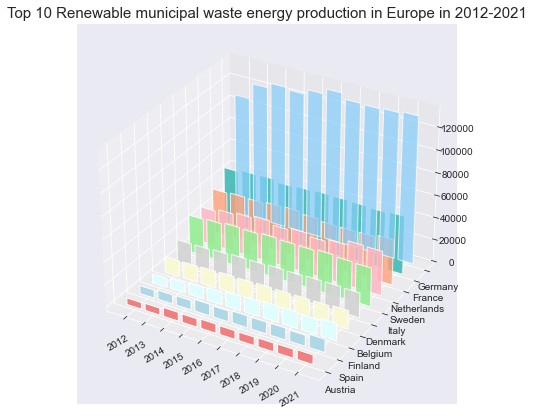

In [177]:
get3dBart(ten_ren,waste,energy[4])

Combining the above data and graphs, it is clear that Several European countries have made significant progress in the new energy sector in the past decade, such as Germany, Italy and France, where new energy capacity has grown rapidly in the past decade, but in some energy types (such as solar), some other countries (such as Spain and Portugal) have grown at a faster rate.

Geothermal energy has a high potential for development in several European countries and has grown rapidly over the past decade, with countries such as Italy and France experiencing faster growth in geothermal energy capacity. The development of solar energy is also very important, and countries such as Germany and France are also experiencing rapid growth in solar energy capacity. Bioenergy capacity such as solid biomass and biogas is also growing to varying degrees in several European countries, such as Germany and Sweden, where solid biomass capacity is growing at a faster rate. Renewable municipal waste is a relatively small source of energy in several European countries, but it is also growing to some extent in some countries (e.g., Germany and France).

## Q2. How do changes of carbon emission payback to national government?<a class="anchor" id="Q2"></a>
In this question, we are going to investigate the effect of carbon emissions from three perspectives, 
- the effect on air quality
- the effect on agricultural production
- the effect on human health 

After looking for and researching the relative data, we take the following data as indicators of the above interested perspectives,
- tiniest pollution particles--PM2.5 pollution
- the FAO indices of agricultural production
- number of premature deaths and number of years of life lost due to PM2.5

To visualise the changing trend of carbon emissions and its potential related objects, we use multiple lines plot with different y-axes. Afterwards, get the correlation coefficients between carbon emissions and the indicators by each countries and draw a box plot to visualize the distribution of correlation coefficients. As a result, we can deduce the relation between emissions and the indicator we have.

As our tables in SQL database are all having primary key (country, year), we can easily join the tables we want to analyse together by SQL Query. After converting back to pd.Dataframe and changing types by the command .astype(), we work out our graphs.

### Correlation between Carbon Emissions and Algriculture Production Index<a class="anchor" id="cei">

In [178]:
con = sqlite3.connect('ceproject.db')
cei_df = pd.read_sql_query('''SELECT *
                          FROM all_ghg_emissions_europe
                          INNER JOIN europe_Gross_Production_Index_Number
                          ON all_ghg_emissions_europe.country = europe_Gross_Production_Index_Number.country
                          AND all_ghg_emissions_europe.year = europe_Gross_Production_Index_Number.year
                          WHERE all_ghg_emissions_europe.year > 2005
                          ORDER BY country ASC;''', con)
con.close();
cei_df = cei_df.T.drop_duplicates().T
cei_df = cei_df.astype({"year":'int64', "emission_value":'float64', "indexnumber":'float64'})

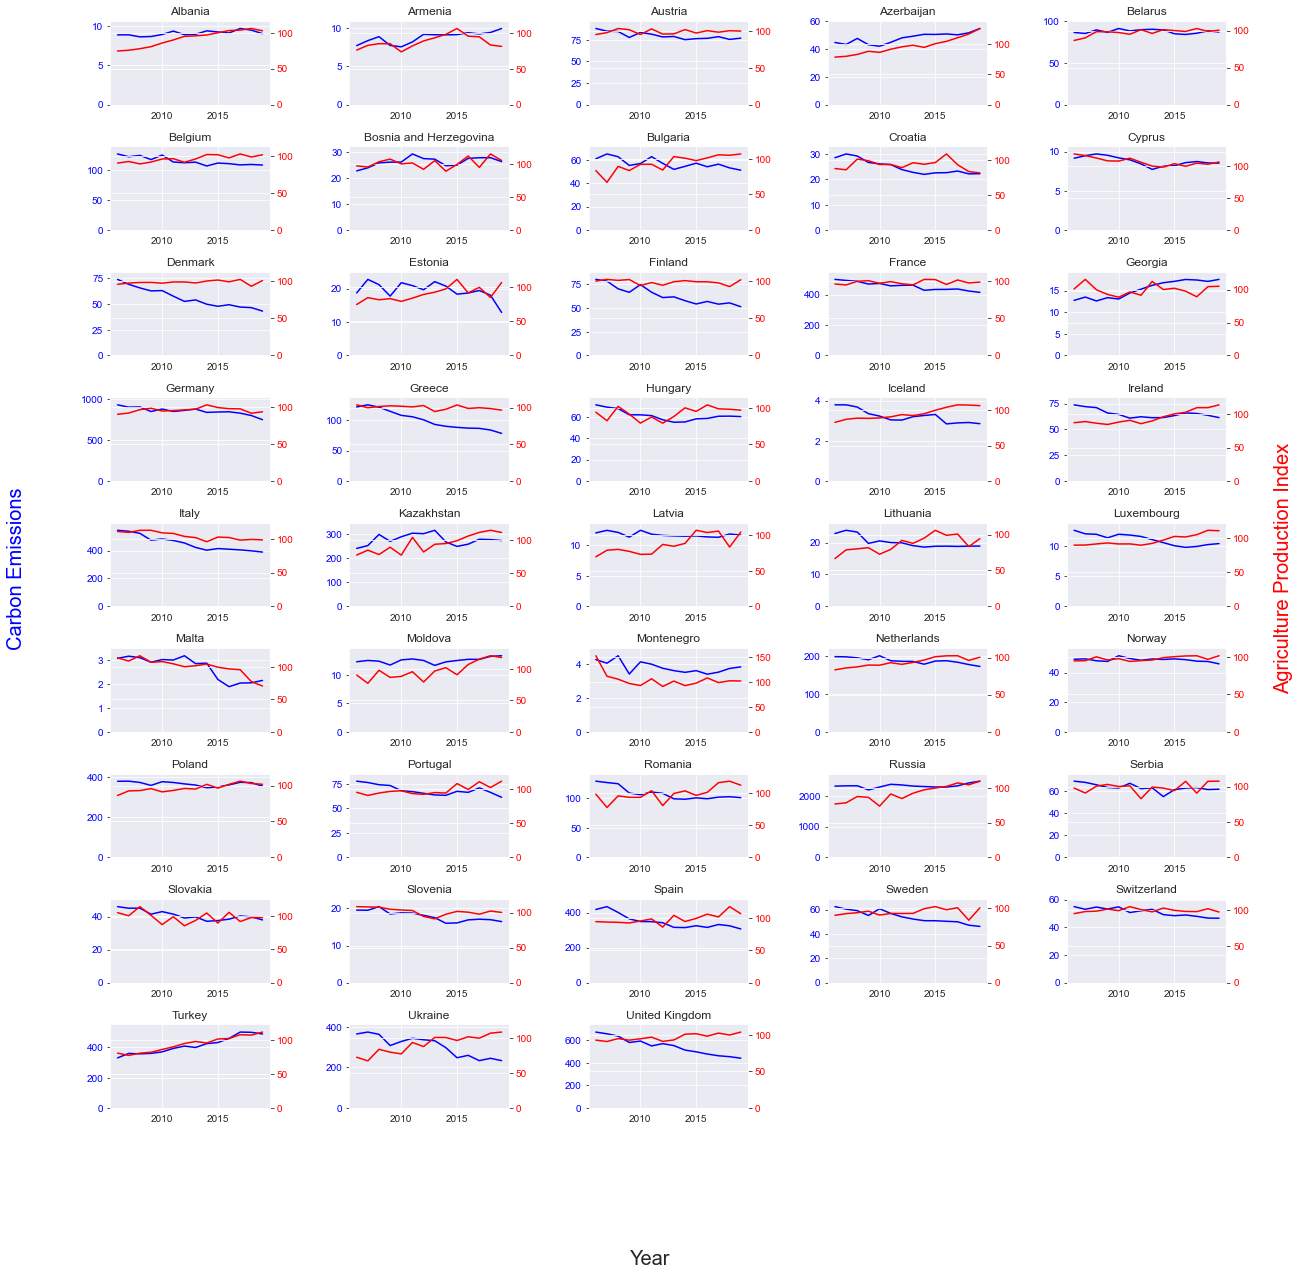

In [179]:
fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(20, 20))
axs = axs.flatten()

for i, country in enumerate(cei_df['country'].unique()):
    country_data = cei_df[cei_df['country'] == country]
    ax = axs[i]
    ax2 = ax.twinx()
    ax.plot(country_data['year'], country_data['emission_value'], 'b-', label='Carbon Emissions')
    ax2.plot(country_data['year'], country_data['indexnumber'], 'r-', label='Agriculture Production Index')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.set_ylim(0, np.max(country_data['emission_value']) * 1.1)
    ax2.set_ylim(0, np.max(country_data['indexnumber']) * 1.1)
    ax.set_title(country)

fig.text(0.5, 0.02, 'Year', ha='center', va='center', fontsize=20)
fig.text(0.94, 0.5, 'Agriculture Production Index', ha='center', va='center', rotation='vertical', color='r', fontsize=20)
fig.text(0.06, 0.5, 'Carbon Emissions', ha='center', va='center', rotation='vertical', color='b', fontsize=20)

for i in range(len(cei_df['country'].unique()), len(axs)):
    axs[i].axis('off')

plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()

From the multiple line plots of 43 countries above, we could find that the carbon emissions were reduced gradually while agricultural production index was increased with fluctuations from 2005 to 2019. The following box plot shows the distribution.

In [180]:
clist = []
for country in cei_df['country'].unique():
    country_data = cei_df[cei_df['country'] == country]
    corr = country_data.corr().loc['emission_value','indexnumber']
    clist.append(corr)
pio.renderers.default = "notebook_connected"
fig = go.Figure()

fig.add_trace(go.Box(
    x=clist,
    name='',
    jitter=0.3,
    pointpos=-1.8,
    boxmean=True,
    hovertemplate='Mean: %{mean:.2f}<br>Median: %{median:.2f}<br>Q1: %{q1:.2f}<br>Q3: %{q3:.2f}<br>Min: %{min:.2f}<br>Max: %{max:.2f}'
))

fig.update_layout(
    title='Correlation between agriculture production index and carbon emissions',
    xaxis_title='correlation coefficients',
    hovermode='closest'
)
fig.update_yaxes(showticklabels=False)

fig.show()

The box plot shows that the median is around -0.17 which is in line with our expectation. It is councluded that there is a negative correlation between carbon emissions and agricultural production, reducing carbon emissions is helpful for grain production.

###  Correlation between Air Quality and Carbon Emissions<a class="anchor" id="cea">

In [181]:
con = sqlite3.connect('ceproject.db')
cea_df = pd.read_sql_query('''SELECT *
                          FROM all_ghg_emissions_europe
                          JOIN pm2_5_pollution_all_areas
                          ON all_ghg_emissions_europe.country = pm2_5_pollution_all_areas.country
                          AND all_ghg_emissions_europe.year = pm2_5_pollution_all_areas.year
                          ORDER BY country ASC;''', con)
con.close();
cea_df = cea_df.T.drop_duplicates().T
cea_df = cea_df.astype({"year":'category', "emission_value":'float64', "population": 'int64', "area":'float64', "pm2_5pollution":'float64', "pm2_5pollution_weighted":'float64'})

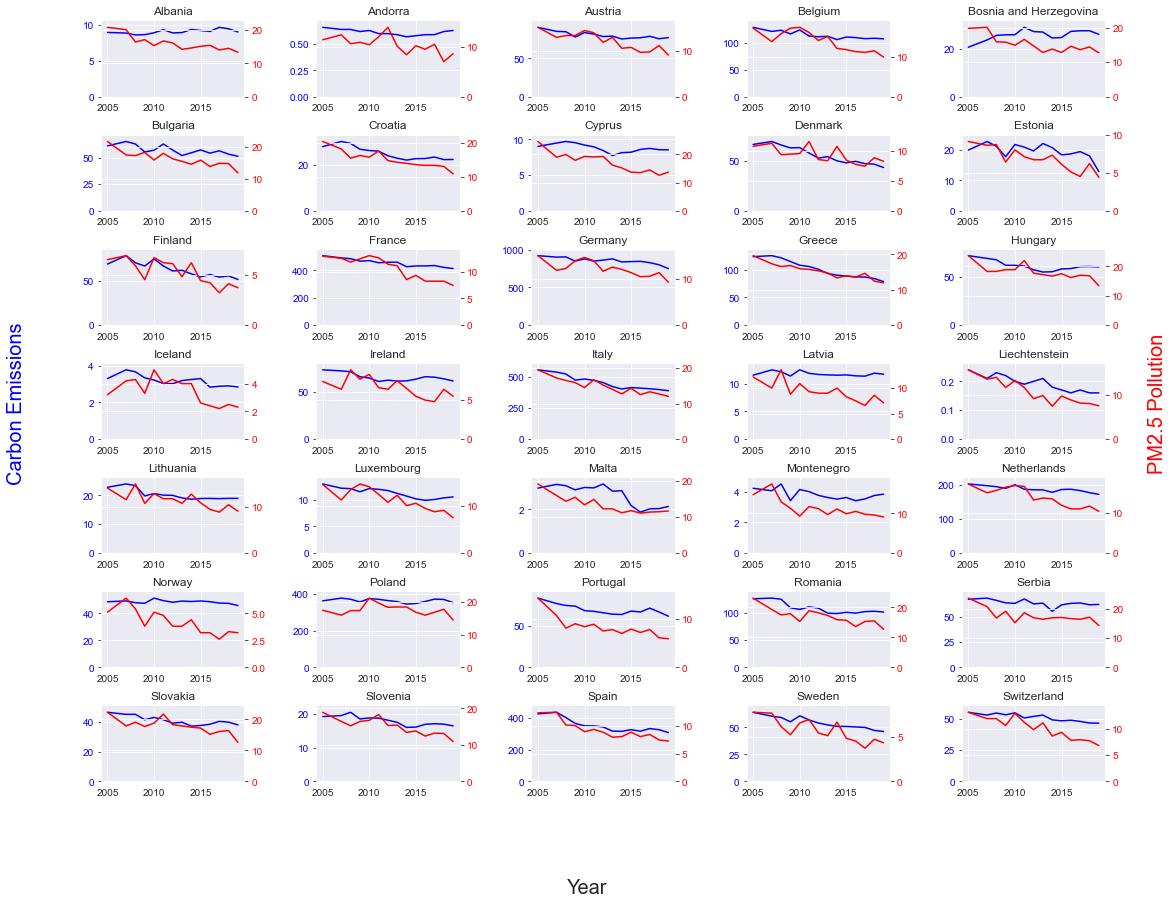

In [182]:
fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(18, 14))
axs = axs.flatten()

for i, country in enumerate(cea_df['country'].unique()):
    country_data = cea_df[cea_df['country'] == country]
    ax = axs[i]
    ax2 = ax.twinx()
    ax.plot(country_data['year'], country_data['emission_value'], 'b-', label='Carbon Emissions')
    ax2.plot(country_data['year'], country_data['pm2_5pollution'], 'r-', label='PM2.5 Pollution')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.set_ylim(0, np.max(country_data['emission_value']) * 1.1)
    ax2.set_ylim(0, np.max(country_data['pm2_5pollution']) * 1.1)
    ax.set_title(country)
    
fig.text(0.5, 0.02, 'Year', ha='center', va='center', fontsize=20)
fig.text(0.94, 0.5, 'PM2.5 Pollution', ha='center', va='center', rotation='vertical', color='r', fontsize=20)
fig.text(0.06, 0.5, 'Carbon Emissions', ha='center', va='center', rotation='vertical', color='b', fontsize=20)

for i in range(len(cea_df['country'].unique()), len(axs)):
    axs[i].axis('off')

plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()


In most above plots the two lines have a consistent change and show a decreased trend between 2005 and 2019.

In [183]:
clist = []
for country in cea_df['country'].unique():
    country_data = cea_df[cea_df['country'] == country]
    corr = country_data.corr().loc['emission_value','pm2_5pollution']
    clist.append(corr)
pio.renderers.default = "notebook_connected"
fig = go.Figure()

fig.add_trace(go.Box(
    x=clist,
    name='',
    jitter=0.3,
    pointpos=-1.8,
    boxmean=True,
    hovertemplate='Mean: %{mean:.2f}<br>Median: %{median:.2f}<br>Q1: %{q1:.2f}<br>Q3: %{q3:.2f}<br>Min: %{min:.2f}<br>Max: %{max:.2f}'
))

fig.update_layout(
    title='Correlation between air quality and carbon emissions',
    xaxis_title='correlation coefficients',
    hovermode='closest'
)
fig.update_yaxes(showticklabels=False)

fig.show()

The box plot indicates that there is a strong positive correlation between carbon emissions and PM2.5 pollution with median value approximately 0.7 and a small interquartile range which means the values cluster tightly around the median value. Therefore the reduction of carbon emissions will be significantlt helpful for in improving the air quality.

### Air Pollution Attributable to Deaths<a class="anchor" id="ced">

In [184]:
con = sqlite3.connect('ceproject.db')
ced_df = pd.read_sql_query('''SELECT *
                          FROM all_ghg_emissions_europe
                          JOIN pm2_5_lifedeath_all_areas
                          ON all_ghg_emissions_europe.country = pm2_5_lifedeath_all_areas.country
                          AND all_ghg_emissions_europe.year = pm2_5_lifedeath_all_areas.year
                          ORDER BY country ASC;''', con)
con.close();
ced_df = ced_df.T.drop_duplicates().T
ced_df = ced_df.astype({"year":'int64', "emission_value":'float64', "pm2_5_Premature_Deaths": 'int64', "pm2_5_Premature_Deaths_LCI":'int64', "pm2_5_Premature_Deaths_LCI":'int64', "pm2_5_Years_Of_Life_Lost":'int64', "pm2_5_Years_Of_Life_Lost_LCI":'int64', "pm2_5_Years_Of_Life_Lost_UCI":'int64'})


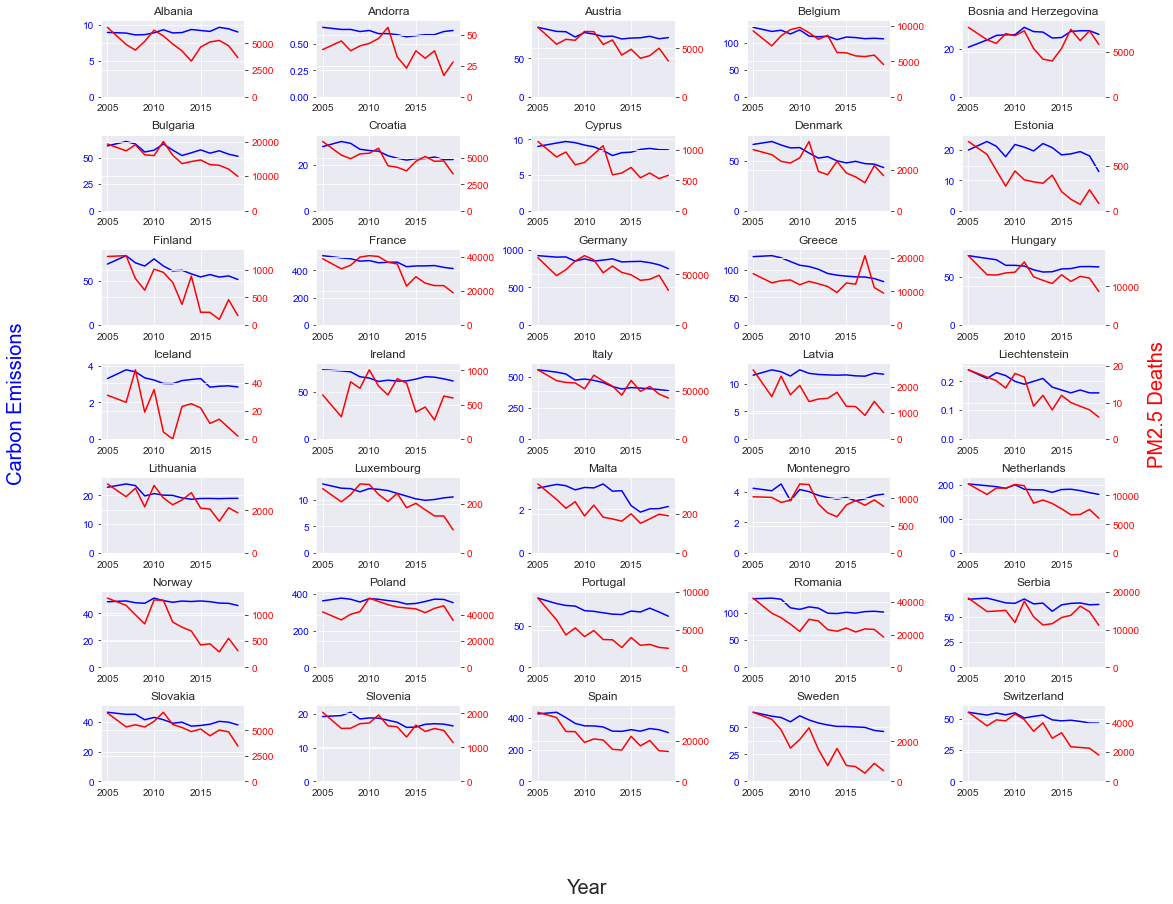

In [185]:
fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(18, 14))
axs = axs.flatten()

for i, country in enumerate(ced_df['country'].unique()):
    country_data = ced_df[ced_df['country'] == country]
    ax = axs[i]
    ax2 = ax.twinx()
    ax.plot(country_data['year'], country_data['emission_value'], 'b-', label='Carbon Emissions')
    ax2.plot(country_data['year'], country_data['pm2_5_Premature_Deaths'], 'r-', label='PM2.5 Deaths')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.set_ylim(0, np.max(country_data['emission_value']) * 1.1)
    ax2.set_ylim(0, np.max(country_data['pm2_5_Premature_Deaths']) * 1.1)
    ax.set_title(country)
    
fig.text(0.5, 0.02, 'Year', ha='center', va='center', fontsize=20)
fig.text(0.94, 0.5, 'PM2.5 Deaths', ha='center', va='center', rotation='vertical', color='r', fontsize=20)
fig.text(0.06, 0.5, 'Carbon Emissions', ha='center', va='center', rotation='vertical', color='b', fontsize=20)

for i in range(len(ced_df['country'].unique()), len(axs)):
    axs[i].axis('off')

plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()


From the above multiple lines plot, there is downward trend for both the carbon emissions and mortality attributable to PM2.5, moreover, the decrease of mortality is much more significant than carbon emissions. So the reducation of carbon emissions is greatly improved the people's health and reduce the mortality rate.

In [186]:
clist = []
for country in ced_df['country'].unique():
    country_data = ced_df[ced_df['country'] == country]
    corr = country_data.corr().loc['emission_value','pm2_5_Premature_Deaths']
    clist.append(corr)
pio.renderers.default = "notebook_connected"
fig = go.Figure()

fig.add_trace(go.Box(
    x=clist,
    name='',
    jitter=0.3,
    pointpos=-1.8,
    boxmean=True,
    hovertemplate='Mean: %{mean:.2f}<br>Median: %{median:.2f}<br>Q1: %{q1:.2f}<br>Q3: %{q3:.2f}<br>Min: %{min:.2f}<br>Max: %{max:.2f}'
))

fig.update_layout(
    title='Correlation between air quality and carbon emissions',
    xaxis_title='correlation coefficients',
    hovermode='closest'
)
fig.update_yaxes(showticklabels=False)

fig.show()

The distribution of correlation visualised by the box plot indicates that the median value is silghtly higher than 0.65. There is also a strong positve correlation between carbon emissions and PM2.5 premature deanths as our expectation.

### Correlation Heat Map<a class="anchor" id="heat"></a>

In [187]:
con = sqlite3.connect('ceproject.db')
cor_df = pd.read_sql_query('''SELECT *
                          FROM all_ghg_emissions_europe
                          JOIN europe_Gross_Production_Index_Number
                          ON all_ghg_emissions_europe.country = europe_Gross_Production_Index_Number.country
                          AND all_ghg_emissions_europe.year = europe_Gross_Production_Index_Number.year
                          JOIN pm2_5_pollution_all_areas
                          ON all_ghg_emissions_europe.country = pm2_5_pollution_all_areas.country
                          AND all_ghg_emissions_europe.year = pm2_5_pollution_all_areas.year
                          JOIN pm2_5_lifedeath_all_areas
                          ON all_ghg_emissions_europe.country = pm2_5_lifedeath_all_areas.country
                          AND all_ghg_emissions_europe.year = pm2_5_lifedeath_all_areas.year
                          ORDER BY country ASC;''', con)
con.close();
cor_df = cor_df.T.drop_duplicates().T
cor_df = cor_df.drop(columns=['population', 'area', 'pm2_5pollution_weighted', 'pm2_5_Premature_Deaths_LCI', 'pm2_5_Premature_Deaths_UCI', 'pm2_5_Years_Of_Life_Lost_LCI', 'pm2_5_Years_Of_Life_Lost_UCI'])
cor_df = cor_df.astype({"year":'category', "emission_value":'float64', "indexnumber":'float64', "pm2_5pollution":'float64', "pm2_5_Premature_Deaths":'int64', "pm2_5_Years_Of_Life_Lost": 'int64'})
cor_df = cor_df.rename({'emission_value': 'E', 'indexnumber': 'PI', 'pm2_5pollution':'PO', 'pm2_5_Premature_Deaths':'PD', 'pm2_5_Years_Of_Life_Lost': 'YLL'}, axis=1)
pio.renderers.default = "notebook_connected"
fig = make_subplots(rows=11, cols=3, subplot_titles=cor_df['country'].unique())
for i, country in enumerate(cor_df['country'].unique()):
    row = i // 3 + 1
    col = i % 3 + 1
    country_data = cor_df[cor_df['country'] == country]
    corr = country_data.corr()
    heatmap = go.Heatmap(z=corr.values,
                         x=corr.columns,
                         y=corr.index,
                         zmin=-1,
                         zmax=1,
                         colorscale='RdBu',
                         colorbar=dict(title='Correlation'),
                         zmid=0)
    fig.add_trace(heatmap, row=row, col=col)
    fig.update_xaxes(title_text='', tickangle=-45, tickfont=dict(size=9), tickmode='array', tickvals=corr.columns)
    fig.update_yaxes(title_text='', tickangle=0, tickfont=dict(size=9), tickmode='array', tickvals=corr.index)

fig.update_layout(title='Correlation Heatmaps for European Countries',
                  height=2500,
                  width=1000,
                  showlegend=False)
fig.show()

'E' stands for 'Carbon Emissions', 'PI' stands for 'Algriculture Production Index', 'PO' stands for 'PM2.5 Pollution', 'PD' stands for 'Premature Deaths Due to PM2.5', and 'YLL' stands for 'Year of Life Lost Due to PM2.5'.

The heat map shows that correlation between carbon emissions and all potential influenced factors therefore we could find the specific correlation coefficients and the difference between countries. In most of countries, the carbon emissions is negatively correlated with production index and positively correlated with air pollution and its attributable deaths. Specifically, Belgium, Bulgaria, Lithuania, Luxembourg, Netherlands ans Spain give all the absolute value of correlation coefficients more than 0.6. In those countries reduction of carbon emissions can give more payback for the society.

However, in Albamia and Bosnia/Herzegovina the carbon emissions is totally opposite correlated with the tree factors. And in Cyprus, Finlannd, Greece, Italy, Malta, Montenegro, Slovakia and Slovenia, the production index shows positive correlation. Among those countries, we find a common point that they are all costal regions or mountainous region (Slovakia). Since then we speculate the unexpected results were due to the geographic factors not included.

## Q3. How effective is renewable energy as a solution to deal with carbon emission?<a class="anchor" id="Q3"></a>
This section involves the integration of data on carbon emissions and renewable energy to compute the percentage change of these two variables for each country from 2012 to 2019. Through visualization of the percentage change using a scatterplot, where each country is represented as a point on the graph, we aim to identify any notable relationships between carbon emissions and renewable energy.

### Relation between Carbon Emissions and Renewable Energy<a class="anchor" id="relation"></a>
By using SQL queries, we have merged the emissions table with the five renewable energy tables. This process has enabled us to compute the total renewable energy production for each country annually. An example of the resultant table is presented below.

In [188]:
con = sqlite3.connect('ceproject.db')
cer_df = pd.read_sql_query('''SELECT *
                          FROM all_ghg_emissions_europe
                          JOIN europe_Geothermal
                          ON all_ghg_emissions_europe.country = europe_Geothermal.country
                          AND all_ghg_emissions_europe.year = europe_Geothermal.year
                          JOIN europe_Solar
                          ON all_ghg_emissions_europe.country = europe_Solar.country
                          AND all_ghg_emissions_europe.year = europe_Solar.year
                          JOIN europe_solidBiofuels
                          ON all_ghg_emissions_europe.country = europe_solidBiofuels.country
                          AND all_ghg_emissions_europe.year = europe_solidBiofuels.year
                          JOIN europe_Biogases
                          ON all_ghg_emissions_europe.country = europe_Biogases.country
                          AND all_ghg_emissions_europe.year = europe_Biogases.year
                          JOIN europe_waste
                          ON all_ghg_emissions_europe.country = europe_waste.country
                          AND all_ghg_emissions_europe.year = europe_waste.year
                          ORDER BY country ASC;''', con)
con.close();
cer_df = cer_df.T.drop_duplicates().T
cer_df = cer_df.astype({"year":'int64', "emission_value":'float64', "Geothermal":'float64', "Solar":'float64', "solidBiofuels":'float64', "Biogases": 'float64', "waste": 'float64'})
col_list= list(cer_df)
col_list.remove('emission_value')
col_list.remove('country')
col_list.remove('year')
cer_df['Total'] = cer_df[col_list].sum(axis=1)
cer_df = cer_df[['country', 'year', 'emission_value', 'Total']]
cer_df.head()

,country,year,emission_value,Total
0,Albania,2012,8.88,9140.000
1,Albania,2013,8.93,8934.000
2,Albania,2014,9.36,8608.000
3,Albania,2015,9.22,9073.000
4,Albania,2016,9.09,8394.817


After obtaining the total renewable energy production and emissions for each country annually, it is possible to calculate the percentage change of both values from the initial year to the most recent year for each country.

In [189]:
df_new = cer_df.groupby('country')['year'].agg(['min', 'max']).reset_index()
df_new.columns = ['country', 'oldest_year', 'newest_year']
df = pd.merge(cer_df, df_new, on='country', how='inner')
df = df[(df['year'] == df['oldest_year']) | (df['year'] == df['newest_year'])]
df = df.drop(columns=['oldest_year', 'newest_year']).reset_index(drop=True)
df_pct_change_emi = df.groupby('country')['emission_value'].pct_change().reset_index(drop=True)
df_pct_change_total = df.groupby('country')['Total'].pct_change().reset_index(drop=True)
percentage_emi = []
countries_name=[]
percentage_total =[]
odd_numbers = [x for x in range(len(df)+1) if x % 2 != 0]
for i in odd_numbers:
    percentage_emi.append(df_pct_change_emi.iloc[i]*100)
    percentage_total.append(df_pct_change_total.iloc[i]*100)
    countries_name.append(df['country'][i])
data = {'country':countries_name, 'percentage_change_in_emission':percentage_emi, 'percentage_change_in_renew':percentage_total}
df = pd.DataFrame(data)
df = df.replace(np.nan, 0)
df.head()

,country,percentage_change_in_emission,percentage_change_in_renew
0,Albania,1.463964,-21.576696
1,Austria,-1.800077,-5.637072
2,Belgium,-3.440264,0.633285
3,Bosnia and Herzegovina,6.323470,170.111345
4,Bulgaria,-10.208370,58.006874


Upon calculating the percentages, we can regard them as coordinates and represent them as a scatter plot.

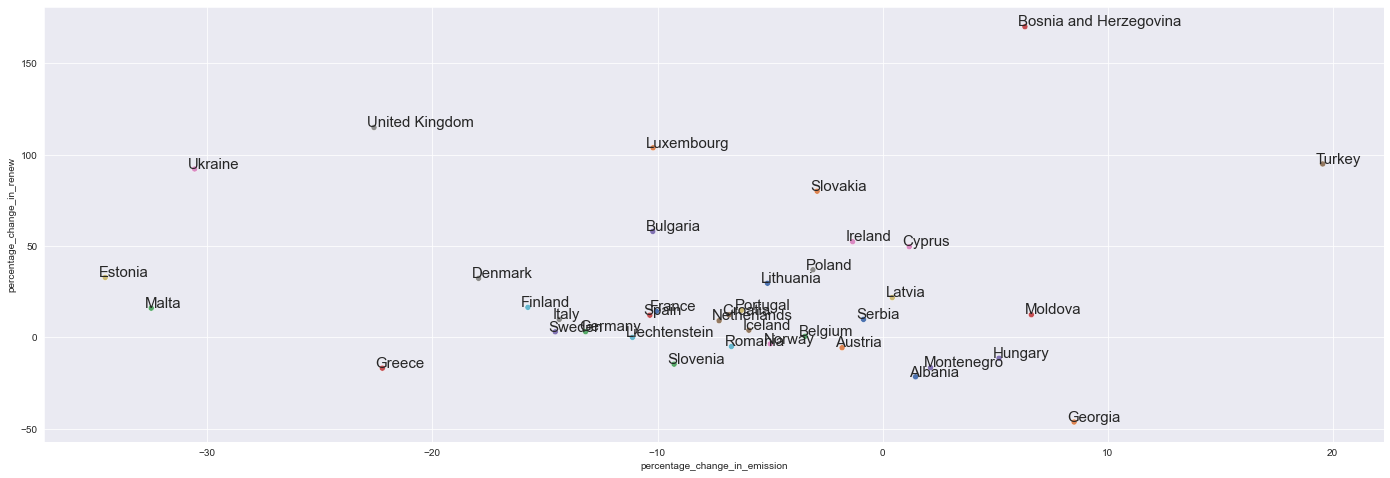

In [190]:
fig, ax = plt.subplots(figsize=(24, 8))
scatter = sns.scatterplot(data=df, x='percentage_change_in_emission', y='percentage_change_in_renew', hue='country', palette='deep');
for i in range(df.shape[0]):
    plt.text(x=df.percentage_change_in_emission[i]-0.3,y=df.percentage_change_in_renew[i]+0.3,s=df.country[i], fontdict=dict(size=15))
ax.get_legend().remove()
plt.show()

The dataset provides us with the coordinates of 38 countries, and we observe no remarkable clusters among them.

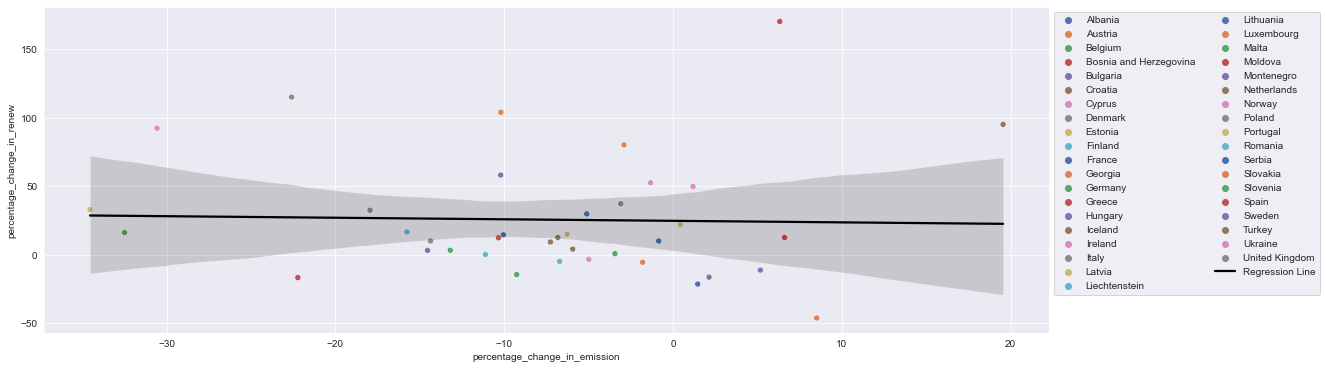

Correlation coefficient: -0.029038554664709646


In [191]:
fig, ax = plt.subplots(figsize=(18, 6))
scatter = sns.scatterplot(data=df, x='percentage_change_in_emission', y='percentage_change_in_renew', hue='country', palette='deep');
sns.regplot(data=df, x='percentage_change_in_emission', y='percentage_change_in_renew', scatter=False, color='black', label='Regression Line')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=2, prop={'size': 10});
plt.show()
correlation = df['percentage_change_in_emission'].corr(df['percentage_change_in_renew'])
print('Correlation coefficient:', correlation)

After plotting the regression line of these points, it is evident that a negative correlation exists between carbon emissions and renewable energy, indicating that an increase in renewable energy production may result in a decrease in carbon emissions, with a correlation coefficient of only -0.03, which is considered to be a weak correlation between the two variables.

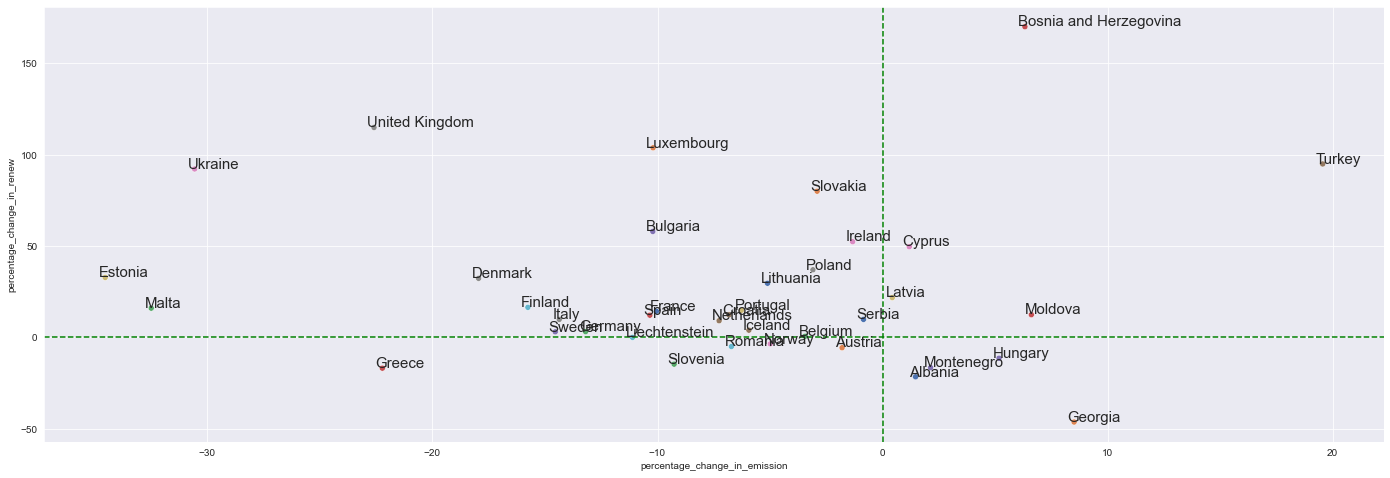

In [192]:
fig, ax = plt.subplots(figsize=(24, 8))
scatter = sns.scatterplot(data=df, x='percentage_change_in_emission', y='percentage_change_in_renew', hue='country', palette='deep');

for i in range(df.shape[0]):
    plt.text(x=df.percentage_change_in_emission[i]-0.3,y=df.percentage_change_in_renew[i]+0.3,s=df.country[i], fontdict=dict(size=15))
ax.get_legend().remove()
plt.axhline(y=0, color='g', linestyle='--')
plt.axvline(x=0, color='g', linestyle='--')
plt.show()

However, by plotting the axis line of the coordinate, it becomes evident that a majority of countries are positioned in the quadrant depicting either a positive increase in renewable energy accompanied by a decrease in carbon emissions, or the converse scenario. This finding suggests that the median correlation between these variables may be more significant.

# Conclusion<a class="anchor" id="con"></a>
In conclusion, this project firstly reveals how renewable energy is developed in countries in Europe, which give us a brief view of how close this topic is to us in our lives. The second part of the analysis shows how can carbon emission contribute to us and the governments, which shows how important this topic could be. In the final part, we look into the relation between emissions and renewable energy by plotting countries in coordinate with the percentage change of these two concepts and discover a very week negative relation.

Here are the limitations of our project, which can influence our result:
1. We do not have enough samples as this project only includes European countries, so the results are not very significant.
2. he sizes of European countries vary, the size of a country affects its stability, with smaller countries experiencing greater fluctuations compared to larger countries. The results may not be fair for larger countries when calculating percentage changes.

Therefore, in the future, we can try to minimize the limitations of our project by using or collecting a more inclusive dataset, and building a more comprehensive analysis model, for example, more variables that can be related both to emissions and renewable energy, and this could able us to illustrate every country much better.